Creating partially labeled dataset
Total labeled samples: 100 out of 10000 (1.00%)
Creating constraints
Number of ml constraints: 59
Number of cl constraints: 27
PCKmeans Iteration 1/10 with max diff 1.2031095516647405
PCKmeans Iteration 2/10 with max diff 0.4401374593665137
PCKmeans Iteration 3/10 with max diff 0.2597416607978795
PCKmeans Iteration 4/10 with max diff 0.16986612769125653
PCKmeans Iteration 5/10 with max diff 0.16874894655709372
PCKmeans Iteration 6/10 with max diff 0.12101184283051247
PCKmeans Iteration 7/10 with max diff 0.17565121684252089
PCKmeans Iteration 8/10 with max diff 0.13034071455838236
PCKmeans Iteration 9/10 with max diff 0.152715910320263
PCKmeans Iteration 10/10 with max diff 0.0918859859927692

===== Metrics Comparison =====
PCKmeans_NMI: 0.4714
KMeans_NMI: 0.4706
PCKmeans_Silhouette: 0.2981
KMeans_Silhouette: 0.3179
PCKmeans_ARI: 0.1091
KMeans_ARI: 0.0957
PCKmeans_DBI: 0.8480
KMeans_DBI: 0.8376


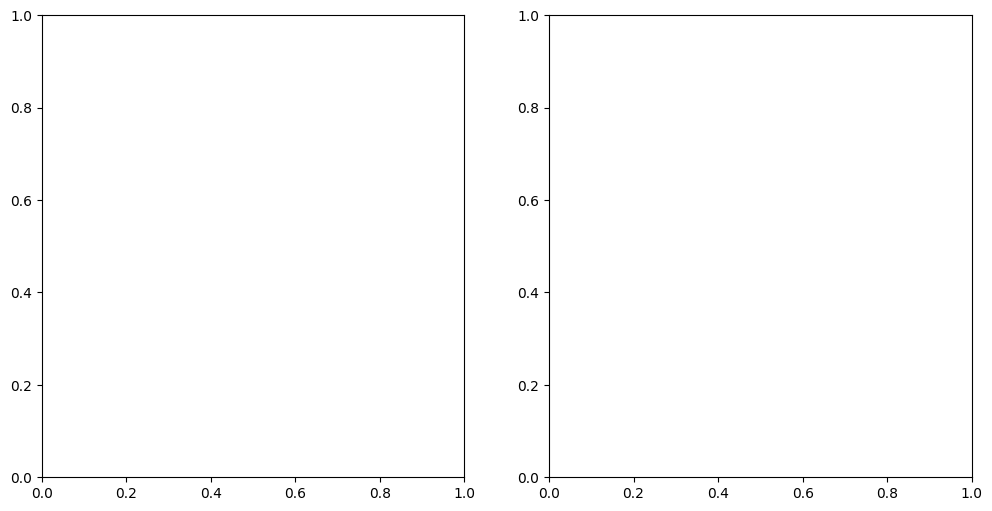

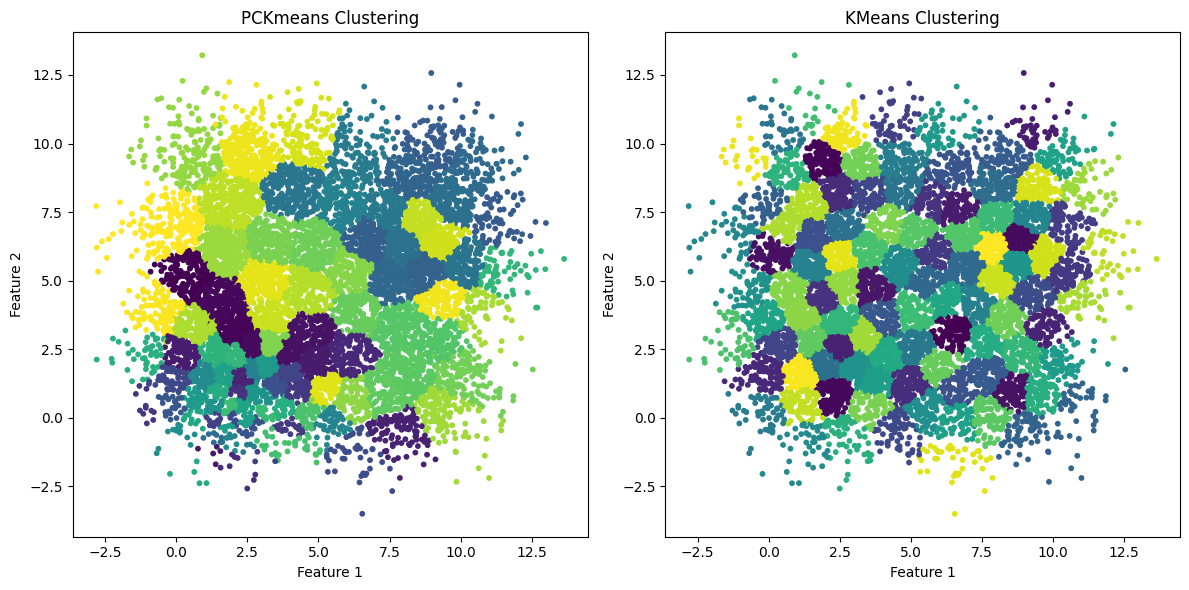

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.cluster import KMeans
from clustering import PCKmeans
from util import create_constraints

%matplotlib inline

def create_sparse_labels(args, dataset):
    '''
    Create a partially labeled dataset from a fully labeled dataset.
    '''
    if args['verbose']:
        print('Creating partially labeled dataset')
    rng = random.Random(args['seed'])
    total_size = len(dataset)

    # Create clean labeled dataset first
    labeled_indices = set(rng.sample(range(total_size), int(args['label_fraction'] * total_size)))

    # Initialize all labels as -1 (unlabeled)
    new_labels = [-1] * total_size

    # First assign correct labels
    for idx in labeled_indices:
        _, label = dataset[idx]
        new_labels[idx] = label

    # Then apply noise to a subset if requested
    noise = args['label_noise']
    if noise > 0.0:
        noisy_count = int(len(labeled_indices) * noise)
        noisy_indices = rng.sample(list(labeled_indices), noisy_count)

        all_labels = list(range(10))  # Adjust based on dataset
        for idx in noisy_indices:
            true_label = new_labels[idx]
            possible_wrong = [l for l in all_labels if l != true_label]
            new_labels[idx] = rng.choice(possible_wrong)
            print(f"Noise applied: idx={idx}, true={true_label} -> noisy={new_labels[idx]}")

    # Create new dataset with these labels
    new_dataset = [(dataset[i][0], new_labels[i]) for i in range(total_size)]

    # Print how many labeled samples by counting non -1 labels 
    labeled_count = sum(1 for label in new_labels if label != -1)
    print(f"Total labeled samples: {labeled_count} out of {total_size} ({labeled_count/total_size*100:.2f}%)")

    return new_dataset, labeled_indices

def test_pckmeans_vs_kmeans(args, n_clusters, n_points_per_cluster):
    """
    Compare PCKmeans and KMeans on synthetic data using multiple metrics.
    """

    # Set random seed for reproducibility
    seed = args['seed']
    np.random.seed(seed)
    random.seed(seed)

    # 1) Generate synthetic data
    means = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(n_clusters)]
    covs = [
        [[random.uniform(0.5, 1.5), 0], [0, random.uniform(0.5, 1.5)]] for _ in range(n_clusters)
    ]

    X_list = []
    y_list = []
    for idx, (mean, cov) in enumerate(zip(means, covs)):
        X_cluster = np.random.multivariate_normal(mean, cov, n_points_per_cluster)
        y_cluster = np.full(n_points_per_cluster, idx)
        X_list.append(X_cluster)
        y_list.append(y_cluster)

    X = np.vstack(X_list)
    y_true = np.concatenate(y_list)

    # 2) Define constraints using external utility function
    dataset = [(X[i], y_true[i]) for i in range(len(X))]
    partial_labeled_data, labeled_indices = create_sparse_labels(args, dataset)
    constraints = create_constraints(args, partial_labeled_data, labeled_indices)

    # 3) Instantiate and run PCKmeans
    pck = PCKmeans(
        k=n_clusters,
        device='cpu',
        plot=False,
        constraints=constraints,
        labeled_indices=labeled_indices,
        max_iter=args['kmeans_iters']
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    pck.cluster(
        X=X, 
        true_labels=y_true, 
        epoch=0, 
        fig=fig, 
        axes=axes, 
        verbose=False
    )

    # Get PCKmeans results
    pck_labels = pck.labels_

    # 4) Instantiate and run KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans_labels = kmeans.fit_predict(X)

    # 5) Evaluate metrics for both methods
    metrics = {
        'NMI': normalized_mutual_info_score,
        'Silhouette': silhouette_score,
        'ARI': adjusted_rand_score,
        'DBI': davies_bouldin_score
    }

    results = {}
    for name, metric in metrics.items():
        if name == 'Silhouette':  # Silhouette score needs the data as well
            results[f'PCKmeans_{name}'] = metric(X, pck_labels)
            results[f'KMeans_{name}'] = metric(X, kmeans_labels)
        elif name == 'DBI':  # DBI needs the data as well
            results[f'PCKmeans_{name}'] = metric(X, pck_labels)
            results[f'KMeans_{name}'] = metric(X, kmeans_labels)
        else:
            results[f'PCKmeans_{name}'] = metric(y_true, pck_labels)
            results[f'KMeans_{name}'] = metric(y_true, kmeans_labels)

    # Print comparison results
    print("\n===== Metrics Comparison =====")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    # 6) Plot the clusters
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].scatter(X[:, 0], X[:, 1], c=pck_labels, cmap='viridis', s=10)
    ax[0].set_title("PCKmeans Clustering")
    ax[0].set_xlabel("Feature 1")
    ax[0].set_ylabel("Feature 2")
    
    ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=10)
    ax[1].set_title("KMeans Clustering")
    ax[1].set_xlabel("Feature 1")
    ax[1].set_ylabel("Feature 2")
    
    plt.tight_layout()
    plt.show()

# Run the test function
if __name__ == '__main__':
    args = {
        'cannot_link_fraction': 0.1,  # This is the fraction you want to use (1.0 = all constraints)
        'must_link_fraction': 1.0,  # This is the fraction you want to use (1.0 = all constraints)
        'label_pattern': 'random',
        'label_noise': 0.0,
        'kmeans_iters': 10,
        'verbose': True,
        'seed': 42,
        'label_fraction': 0.01  # Fraction of labeled data
    }
    n_clusters = 100  # Define number of clusters here
    n_points_per_cluster = 100  # Define points per cluster here
    test_pckmeans_vs_kmeans(args, n_clusters, n_points_per_cluster)
